In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

<div class="alert alert-block alert-info">
This notebook saves hydrological variables aggregated at the basin scale for all available datasets
</div>

# 1. Run through datasets and selected basins

We select the basins we want to study.

In [2]:
approximate=True # 5 approximate climate zones, or 31 smaller ones 
basins=load_basins_data(approximate)

In [3]:
# we select basins larger than 65 000 km2
selected_basins=basins.loc[basins['RASTAREA']>=6.5e4,['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','RASTAREA','NB_RUNOFF','geometry']]

# remove Greenland and Antarctica if they have been selected
to_remove=['GREENLAND','ANTARCTICA']
for remove_basin in to_remove:
    if np.sum(selected_basins.index.isin([remove_basin]))>0:
        selected_basins.drop(remove_basin,inplace=True)

Nbasins=selected_basins.shape[0]
print("You selected {} basins, among which \n {} belong to equatorial zone \n {} to arid zone \n {} to warm temperate zone \n {} to snow zone \n {} to polar zone".format(Nbasins,
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='A'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='B'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='C'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='D'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='E'].shape[0]))

You selected 155 basins, among which 
 28 belong to equatorial zone 
 44 to arid zone 
 31 to warm temperate zone 
 51 to snow zone 
 1 to polar zone


We plot selected_basins

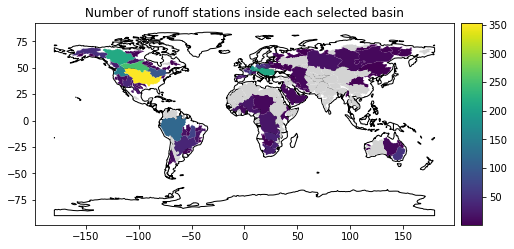

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

selected_basins_plot=selected_basins.copy()
selected_basins_plot['NB_RUNOFF']=np.where(selected_basins['NB_RUNOFF']==0,np.nan,selected_basins['NB_RUNOFF'])

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
selected_basins_plot.plot(ax=ax,column='NB_RUNOFF',legend=True,cax=cax,missing_kwds={"color": "lightgrey",})
ax.set_title("Number of runoff stations inside each selected basin")
plt.show()

List of datasets available for each hydrological variable

In [12]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','MERRA2','MOD16','SSEBop']
list_data_PET=['CRU','GLEAM','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid']
# we do not run over GRACE_ITSG_grid because the dataset is already provided with basin averages
# also TWS_uncertainty with GRACE_JPL_mascons

For each hydrological variable, loop over datasets, compute monthly data per basin and store them

In [11]:
hydro_var_name='PET'
#hydro_var_name='TWS_uncertainty'
for data in list_data_PET:
#for data in ['GRACE_JPL_mascons']:
    (spatial_grid,hydro_grid,time_hydro)=load_hydro_data(hydro_var_name,data,
                                fill_value=dict_fill_value[data],version=version_data[data])

    # dataframe to store results
    col=['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_hydro]
    df1=pd.DataFrame(np.nan*np.ones((selected_basins.shape[0],len(col))),index=selected_basins.index,columns=col)
    df2=pd.DataFrame(np.nan*np.ones((selected_basins.shape[0],len(col)-2)),index=selected_basins.index,columns=col[1:-1])
    
    pbar=ProgressBar()
    for basin_name in pbar(selected_basins.index):
        my_basin=basins.loc[[basin_name],'geometry']
        final_selection=find_coordinates_inside_basin(my_basin,spatial_grid,basins)

        hydro_basin=hydro_grid.loc[final_selection.index]
        nb_missing_values=hydro_basin.loc[:,['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]].isna().sum()
        if np.min(nb_missing_values)>0: # there is a hole
            print("Hole in {} for {}_{}".format(basin_name,hydro_var_name,data))
            

        # fill missing values
        hydro_basin,filling=my_fillna(hydro_basin,hydro_var_name,time_hydro,data,version=version_data[data])
        
        if hydro_var_name=='R' and basin_name=='KASPIAN SEA (DL)':
            col=['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]
            hydro_basin[col]=np.where(np.isnan(hydro_basin[col]),0,hydro_basin[col])
            filling=True
        
        if filling:
            hydro_mean_basin,hydro_mean_basin_filtered=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro,data,version=version_data[data])
            df1.loc[basin_name]=hydro_mean_basin.values
            df2.loc[basin_name]=hydro_mean_basin_filtered.values
        
        else:
            # months with no missing value
            col=['{} {}'.format(hydro_var_name,d.date()) for d in time_hydro]
            col2=np.sum(np.isnan(hydro_basin[col]),axis=0)==0

            # spatial average
            hydro_mean_basin,hydro_mean_basin_filtered=hydrological_variables_basin_filtered(hydro_basin,hydro_var_name,
                                                                time_hydro[np.where(col2)[0]],data,version=version_data[data])
            # save
            df1.loc[basin_name].iloc[np.where(col2)]=hydro_mean_basin.values
            df2.loc[basin_name].iloc[np.where(col2)[0][1:-1]-1]=hydro_mean_basin_filtered.values
        
        
            
    df1.to_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data))
    df2.to_csv('../results/hydrology/{}_{}_monthly_filtered.csv'.format(hydro_var_name,data))

Hole in KASPIAN SEA (DL) for PET_CRU


Hole in NEVA for PET_CRU


100% |########################################################################|


Hole in ODER RIVER for PET_GLEAM


Hole in COLUMBIA RIVER for PET_GLEAM


Hole in ALBANY RIVER for PET_GLEAM
Hole in SAGUENAY (RIVIERE) for PET_GLEAM
Hole in NOTTAWAY for PET_GLEAM


Hole in MOOSE RIVER (TRIB. HUDS for PET_GLEAM


Hole in ST.LAWRENCE for PET_GLEAM


Hole in MISSISSIPPI RIVER for PET_GLEAM


Hole in COLORADO RIVER (PACIFIC for PET_GLEAM


Hole in YUKON RIVER for PET_GLEAM


Hole in INDUS for PET_GLEAM


Hole in HUAI HE for PET_GLEAM


Hole in MEKONG for PET_GLEAM
Hole in MACKENZIE RIVER for PET_GLEAM


Hole in NILE for PET_GLEAM
Hole in BRAHMAPUTRA for PET_GLEAM


Hole in ANADYR for PET_GLEAM


Hole in SANTIAGO for PET_GLEAM


Hole in PECHORA for PET_GLEAM


Hole in SENEGAL for PET_GLEAM


Hole in MAGDALENA for PET_GLEAM


Hole in ORINOCO for PET_GLEAM


Hole in CONGO for PET_GLEAM


Hole in OB for PET_GLEAM


Hole in AMAZONAS for PET_GLEAM


Hole in TAZ for PET_GLEAM


Hole in TOCANTINS for PET_GLEAM


Hole in SHIRE for PET_GLEAM
Hole in PARANA for PET_GLEAM


Hole in BACK RIVER for PET_GLEAM


Hole in GANGES for PET_GLEAM
Hole in YANA for PET_GLEAM


Hole in DEATH VALLEY (DL) for PET_GLEAM


Hole in ATACAMA (DL) for PET_GLEAM


Hole in LAKE CHAD (DL) for PET_GLEAM


Hole in LAKE BALKHASH (DL) for PET_GLEAM


Hole in HIGHLAND OF TIBET (DL) for PET_GLEAM


Hole in GOBI (DL) for PET_GLEAM


Hole in HELMAND (AFGHANISTAN) ( for PET_GLEAM


Hole in KASPIAN SEA (DL) for PET_GLEAM
Hole in ARAL SEA (DL) for PET_GLEAM
Hole in WESTERN SAHARA (DL) for PET_GLEAM


Hole in ARAVALLI (INDIA) (DL) for PET_GLEAM
Hole in THELON RIVER for PET_GLEAM
Hole in NORTHERN DVINA(SEVERNAY for PET_GLEAM


Hole in YENISEI for PET_GLEAM


Hole in VUOKSI for PET_GLEAM
Hole in NEVA for PET_GLEAM


Hole in COPPER RIVER for PET_GLEAM


Hole in VOLGA for PET_GLEAM
Hole in LENA for PET_GLEAM


Hole in CHURCHILL RIVER for PET_GLEAM


Hole in CANIAPISCAU for PET_GLEAM
Hole in NELSON RIVER for PET_GLEAM


Hole in HAYES RIVER (TRIB. HUDS for PET_GLEAM


Hole in SEVERN RIVER (TRIB. HUD for PET_GLEAM
Hole in AMUR for PET_GLEAM


Hole in GRANDE RIVIERE for PET_GLEAM
Hole in CHURCHILL, FLEUVE (LABR for PET_GLEAM
Hole in DNIEPR for PET_GLEAM


100% |########################################################################|
100% |########################################################################|
